In [4]:
#Auto reload is used to ensure changes made to utils show up immediatly
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Leasing Approvals Model Training and Selection


## Selection Process

The production model will be selected by running a number of experiments varing model types, hyperparamters and feature engineering. The top perfroming model as measured by the selection criteria will be selected.

The following experiments will be conducted:

1. Imputing the missing values for 'Equipment Type'
    1.1 Baseline
    1.2 Default Model( 4 )
vs dropping null rows, vs dropping the column
2. 
## Model Selection Criteria

Because we want to minimize poor leads without missing opportunities, we want a model that has a high **F1 Score**. We will still evaluate other metrics such as accuracy, precision, and recall to ensure the model is performing well but  the primary metric will be the F1 Score. In addition to the F1 Score, we will also evaluate against time it takes to train the model and to make predictions.









In [3]:


import pandas as pd




## Data Preparation

### Load Data Sets

Load the data sets that were an anlyzed in the EDA notebook.

In [5]:
funding_results_for_modelling = pd.read_csv('data/funding_results.csv', parse_dates=['Application Date'])
rates_for_modelling = pd.read_csv('data/rates.csv', parse_dates=['Date'])


### Cleaning Datasets

Drop columns that are not needed for the model, remove null values and outliers.

In [6]:

from datetime import datetime
#Clean Funding Results Data

#Drop unnecessary columns
#Equipment Type: Dropped because almost 50% were empty 
#Business Type: Dropped becaue all were the same type
#Year Incorporated: Dropped because it is highly correlated with Years in Business
#Status: Replaced with Encoded Status
funding_results_for_modelling_reduced_columns = funding_results_for_modelling.drop(columns=['Equipment Type', 'Business Type', 'Year Incorporated', 'Status'])
cleaned_funding_results=funding_results_for_modelling_reduced_columns.dropna()

#Clean Rates Data
#Convert 'Rate' column in rates data to float, coerce errors to NaN, then drop rows where 'Rate' is not valid
rates_for_modelling['Rate'] = pd.to_numeric(rates_for_modelling['Rate'], errors='coerce')
cleaned_rates=rates_for_modelling.dropna(subset=['Rate'])



### Merging Datasets

Combining the two data sets on the 'Application Date' and 'Date' columns

In [8]:
# Using a left join to ensure we keep all the funding data even if there's no matching rate
merged_df_for_modelling = pd.merge(cleaned_funding_results, cleaned_rates, left_on='Application Date', right_on='Date', how='left')

# Drop the redundant 'Date' column from rates after the merge
cleaned_merged_df=merged_df_for_modelling.drop(columns=['Date'])

cleaned_merged_df.head()

,Funder ID,Company Location,Company Size,Annual Revenue,Industry Sector,Lease Term,Lease Amount,Previous Lease History,Application Date,Years in Business,Encoded Status,Rate
0,1,NB,51-100,5528010,Industrial & Material Handling,5,28173.881010,No,2020-09-04,32,1,0.5
1,3,NB,51-100,5528010,Industrial & Material Handling,5,28173.881010,No,2020-09-04,32,1,0.5
2,4,NB,51-100,5528010,Industrial & Material Handling,5,28173.881010,No,2020-09-04,32,1,0.5
3,1,NB,51-100,8407005,Industrial & Material Handling,1,161304.880881,No,2020-02-14,30,1,2.0
4,3,NB,51-100,8407005,Industrial & Material Handling,1,161304.880881,No,2020-02-14,30,1,2.0


## Feature Engineering

, and create new features

### Split the data into training and testing sets

In [27]:
from sklearn.model_selection import train_test_split

# Define the features (X) and target (y)
X = cleaned_merged_df.drop(columns=['Encoded Status'])  # Features
y = cleaned_merged_df['Encoded Status']                 # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Engineering

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Calculate 'Years in Business' by subtracting 'Year Incorporated' from the current year
current_year = datetime.now().year
funding_results_for_modelling['Years in Business'] = current_year - funding_results_for_modelling['Year Incorporated']

#Map the 'Status' column to 1 and 0
funding_results_for_modelling['Encoded Status'] = funding_results_for_modelling['Status'].map({'approved': 1, 'denied': 0})

# Define columns for transformations
numerical_features = ['Lease Amount', 'Annual Revenue', 'Years in Business', 'Lease Term', 'Rate']
categorical_features = ['Funder ID', 'Industry Sector', 'Company Location','Previous Lease History']
ordinal_features = ['Company Size']

# Define Preprocessing Steps

# For numerical features, we'll apply StandardScaler
numerical_transformer = StandardScaler()

# For categorical features, we'll apply OneHotEncoder
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# For ordinal features, we'll apply OrdinalEncoder
# Define the categories for the ordinal features in the desired order
ordinal_categories = [
    ['1-50', '51-100','100+'] # Categories for 'Company Size'
]
ordinal_transformer = OrdinalEncoder(categories=ordinal_categories)


# Create ColumnTransformer to apply transformations to specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ]
)




### Create Baseline Model

In [29]:
from utils.data_modelling_helpers import train_baseline_model

#Train Baseline Model for comparison of future models
baseline_model = train_baseline_model(X_train, y_train, cv=5, scoring='f1', problem_type='classification')

Baseline model for classification (predicts the most frequent class) is trained.
Training Baseline(classification) model...


### Setup Pipeline 

Setup the pipeline to be used for model training models in grid search. Inserting Logistic Regression as a placeholder model that will be targetted and swapped out during model selection.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Define the pipeline
# This section defines the pipeline that includes preprocessing steps and other steps that will be applied to the data.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing stage (e.g., scaling, encoding).
    # ('under_sampler', RandomUnderSampler()),  # For testing purposes handles class imbalance by undersampling the majority class.
    # undersampline preformed extremly poorly
    ('smote', SMOTE()),  # For testing handles imbalance with SMOTE by oversampling the minority class.
    ('poly', PolynomialFeatures()),  # Generates polynomial features to capture nonlinear relationships.
    ('model', LogisticRegression())  # The final model for classification (can be swapped out during model selection).
])

### Basline Models for Comparision

Train models with out hyperparameter tuning to understand the performance of the data with default parameters

Training KNN model...
Training Decision Tree model...
Training SVC model...
Training Logistic Regression model...
Training Random Forest model...

Best Model Evaluation Results (Top model marked with *):
+--------------------------+------------+-------------+----------+------------+-------------------+
| Model                    |   Accuracy |   Precision |   Recall |   F1 Score | Best Parameters   |
+==========================+============+=============+==========+============+===================+
| Random Forest *          |     0.9008 |      0.8888 |   0.9008 |     0.8943 | {}                |
+--------------------------+------------+-------------+----------+------------+-------------------+
| Baseline(classification) |     0.9233 |      0.8525 |   0.9233 |     0.8865 | {}                |
+--------------------------+------------+-------------+----------+------------+-------------------+
| Logistic Regression      |     0.8550 |      0.9104 |   0.8550 |     0.8769 | {}              

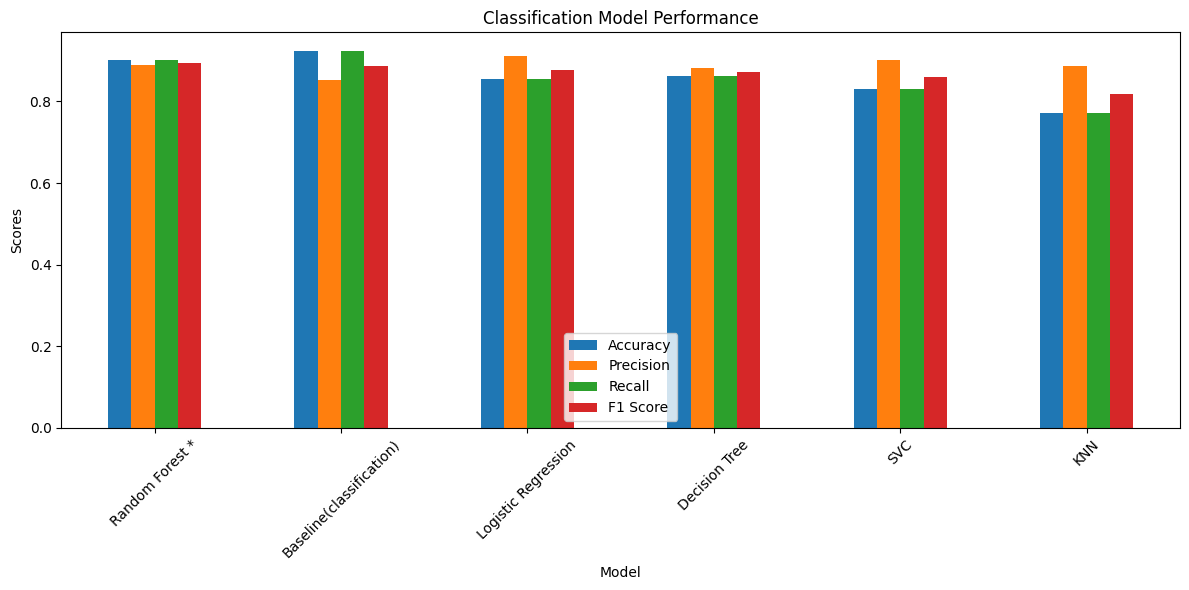


Model Hyperparameters:
1. KNN: 
2. Decision Tree: 
3. SVC: 
4. Logistic Regression: 
5. Random Forest: 
6. Baseline(classification): 


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils.data_modelling_helpers import ModelWrapper, evaluate_models, train_models

knn_model_baseline   = ModelWrapper(KNeighborsClassifier(), {}, 'KNN')
decision_tree_model_baseline = ModelWrapper(DecisionTreeClassifier(), {}, 'Decision Tree')
svc_model_baseline = ModelWrapper(SVC(), {}, 'SVC')
logistic_regression_model_baseline = ModelWrapper(LogisticRegression(max_iter=500), {}, 'Logistic Regression')
random_forest_model_baseline = ModelWrapper(RandomForestClassifier(), {}, 'Random Forest')

# List of models to be evaluated.
# will be passed to the pipeline for tuning and evaluation.
model_list = [
    knn_model_baseline,
    decision_tree_model_baseline,
    svc_model_baseline,
    logistic_regression_model_baseline,
    random_forest_model_baseline
]

baseline_models = train_models(model_list, pipeline, X_train, y_train, cv=5, scoring='f1')
baseline_models_and_baseline = baseline_models + [baseline_model]
evaluate_models(baseline_models_and_baseline, X_test, y_test, model_type='classification', scoring='f1')

### Setup Search Grid

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils.data_modelling_helpers import ModelWrapper


# Define hyperparameter grids for each model that will be used during model training and evaluation.
# Each dictionary defines a set of hyperparameters to tune for the corresponding model.
knn_param_grid = {
    'model__n_neighbors': [3, 5, 10, 15],
    'model__weights': ['uniform', 'distance'],
    'poly__degree': [1, 2]
}

decision_tree_param_grid = {
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 10, 20],
    'poly__degree': [1, 2]
}

svc_param_grid = {
    'model__kernel': ['linear', 'rbf'],
    'model__C': [0.1, 1, 10],
    'poly__degree': [1, 2],
}

logistic_regression_param_grid = {
    'model__C': [0.1, 1, 10],
    'model__solver': ['liblinear'],
    # 'poly__degree': [1,2, 3], removing additonal paramters that did not improve model when tried
    # 'model__penalty': ['l1', 'l2'],removing additonal paramters that did not improve model when tried
    'poly__degree': [2],
    'model__penalty': ['l1'],
    'model__class_weight': [None, 'balanced'],
    'model__max_iter': [500]
}

random_forest_param_grid = {
    'model__n_estimators': [300, 400, 500, 600],
    'model__max_depth': [None, 50, 100],
    'poly__degree': [1, 2],
    'model__criterion': ['gini', 'entropy']
}


# Wrap each model with its corresponding hyperparameter grid creates ModelWrapper objects for each model, 
# pairing the model with its hyperparameters.
# These wrappers will be used for training, evaluating, and tuning each model during the pipeline execution.
knn_model = ModelWrapper(KNeighborsClassifier(), knn_param_grid, 'KNN')
decision_tree_model = ModelWrapper(DecisionTreeClassifier(), decision_tree_param_grid, 'Decision Tree')
svc_model = ModelWrapper(SVC(), svc_param_grid, 'SVC')
logistic_regression_model = ModelWrapper(LogisticRegression(), logistic_regression_param_grid, 'Logistic Regression')
random_forest_model = ModelWrapper(RandomForestClassifier(class_weight='balanced'), random_forest_param_grid, 'Random Forest')

# List of models to be evaluated. These models, with their associated hyperparameter grids,
# will be passed to the pipeline for tuning and evaluation.
model_list = [
    knn_model,
    decision_tree_model,
    svc_model,
    logistic_regression_model,
    random_forest_model
]




### Retrain Models with Tuned Hyperparameters

In [33]:
from utils.data_modelling_helpers import train_models

best_models = train_models(model_list, pipeline, X_train, y_train, cv=5, scoring='f1')

Training KNN model...
Training Decision Tree model...
Training SVC model...
Training Logistic Regression model...
Training Random Forest model...


### Evaluate Tuned Models


Best Model Evaluation Results (Top model marked with *):
+--------------------------+------------+-------------+----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Model                    |   Accuracy |   Precision |   Recall |   F1 Score | Best Parameters                                                                                                                                      |
+==========================+============+=============+==========+============+======================================================================================================================================================+
| SVC *                    |     0.8909 |      0.9077 |   0.8909 |     0.8984 | {'model__C': 10, 'model__kernel': 'linear', 'poly__degree': 2}                                                                                       |
+-----------------

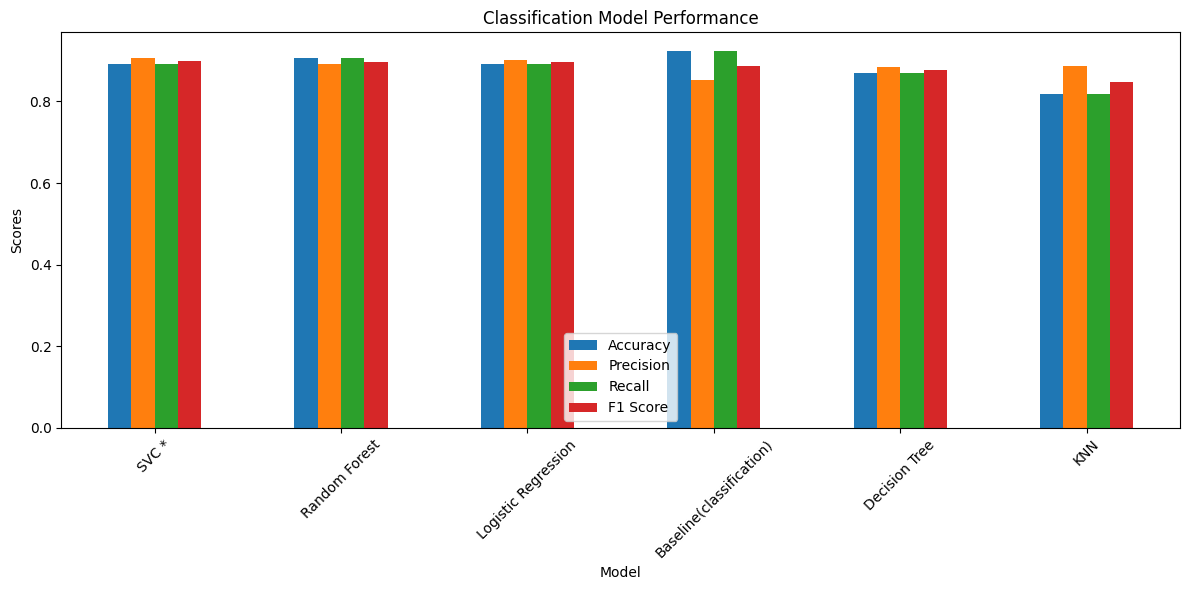


Model Hyperparameters:
1. KNN: model__n_neighbors=3, model__weights=distance, poly__degree=1
2. Decision Tree: model__max_depth=None, model__min_samples_split=10, poly__degree=2
3. SVC: model__C=10, model__kernel=linear, poly__degree=2
4. Logistic Regression: model__C=10, model__class_weight=balanced, model__max_iter=500, model__penalty=l1, model__solver=liblinear, poly__degree=2
5. Random Forest: model__criterion=entropy, model__max_depth=None, model__n_estimators=600, poly__degree=1
6. Baseline(classification): 


In [34]:
from utils.data_modelling_helpers import evaluate_models

best_models_and_baseline = best_models + [baseline_model]
evaluate_models(best_models_and_baseline, X_test, y_test, model_type='classification', scoring='f1')


### Improve Best Models with Ensemble Methods

In [36]:
#Traing Ensemble Models
from sklearn.ensemble import BaggingClassifier


# Evaluate the ensemble model(Bagging)
# Set up the parameter grid for the Bagging model
bagging_param_grid = {
    'model__n_estimators': [10, 30, 50],
    'model__base_estimator': [SVC(C=10, kernel='linear')], #<-- when used gives 0.9 F1. Cause deprecation warnings
    'poly__degree': [2],
}

# Define the Bagging model
# bagging_model = ModelWrapper(BaggingClassifier(SVC(C=10, kernel='linear')), bagging_param_grid, 'Bagging')
bagging_model = ModelWrapper(BaggingClassifier(), bagging_param_grid, 'Bagging')

#Train and Evaluate Bagging Model
bagging_best_models = train_models([bagging_model], pipeline, X_train, y_train, cv=5, scoring='f1')


Training Bagging model...



Best Model Evaluation Results (Top model marked with *):
+--------------------------+------------+-------------+----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Model                    |   Accuracy |   Precision |   Recall |   F1 Score | Best Parameters                                                                                                                                      |
+==========================+============+=============+==========+============+======================================================================================================================================================+
| Bagging *                |     0.8902 |      0.9091 |   0.8902 |     0.8985 | {'model__base_estimator': SVC(C=10, kernel='linear'), 'model__n_estimators': 30, 'poly__degree': 2}                                                  |
+-----------------

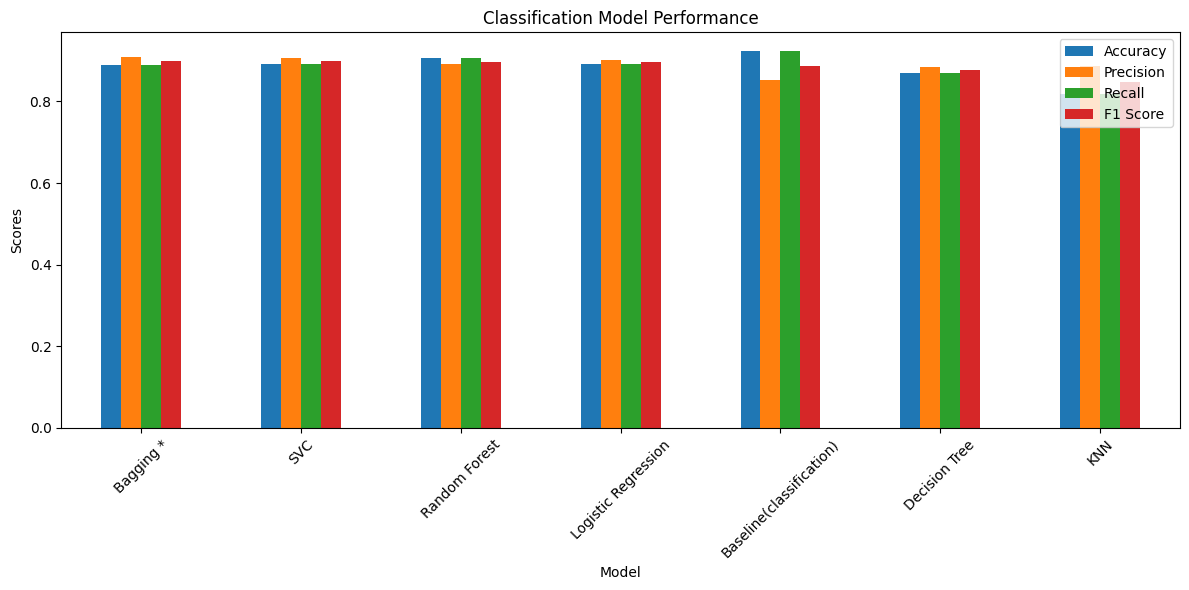


Model Hyperparameters:
1. KNN: model__n_neighbors=3, model__weights=distance, poly__degree=1
2. Decision Tree: model__max_depth=None, model__min_samples_split=10, poly__degree=2
3. SVC: model__C=10, model__kernel=linear, poly__degree=2
4. Logistic Regression: model__C=10, model__class_weight=balanced, model__max_iter=500, model__penalty=l1, model__solver=liblinear, poly__degree=2
5. Random Forest: model__criterion=entropy, model__max_depth=None, model__n_estimators=600, poly__degree=1
6. Bagging: model__base_estimator=SVC(C=10, kernel='linear'), model__n_estimators=30, poly__degree=2
7. Baseline(classification): 


In [37]:
best_models_and_bagging_and_baseline = best_models + bagging_best_models + [baseline_model]
evaluate_models(best_models_and_bagging_and_baseline, X_test, y_test, model_type='classification', scoring='f1')

KNN
                   Feature  Importance
5               Lease Term    0.025123
1         Company Location    0.017593
9        Years in Business    0.016960
10                    Rate    0.014075
4          Industry Sector    0.007600
6             Lease Amount    0.006334
7   Previous Lease History    0.003519
2             Company Size    0.003378
3           Annual Revenue    0.002182
8         Application Date    0.000000
0                Funder ID   -0.032864


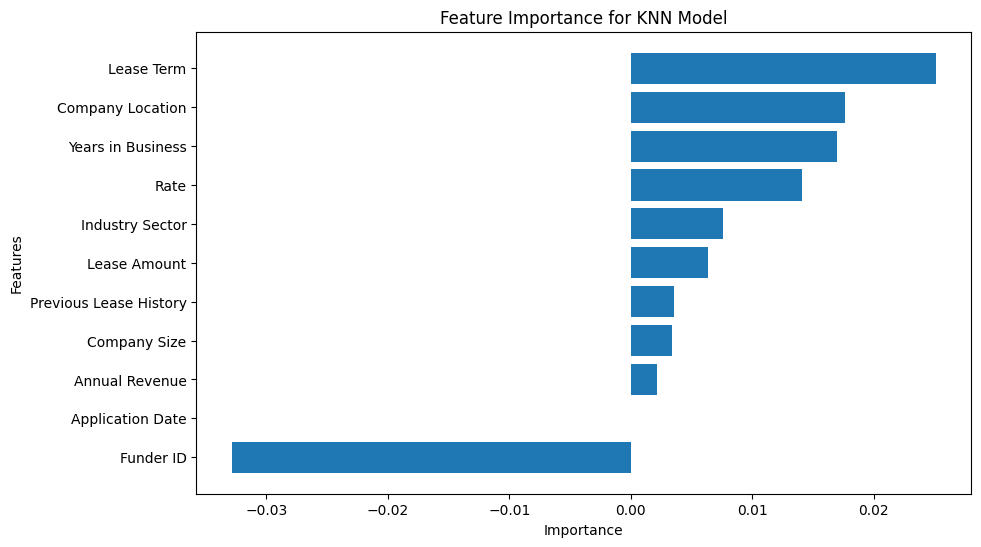

Decision Tree
                   Feature  Importance
3           Annual Revenue    0.038424
5               Lease Term    0.030823
2             Company Size    0.020056
6             Lease Amount    0.018015
9        Years in Business    0.015975
4          Industry Sector    0.012949
7   Previous Lease History    0.012386
1         Company Location    0.004363
10                    Rate    0.004011
8         Application Date    0.000000
0                Funder ID   -0.004152


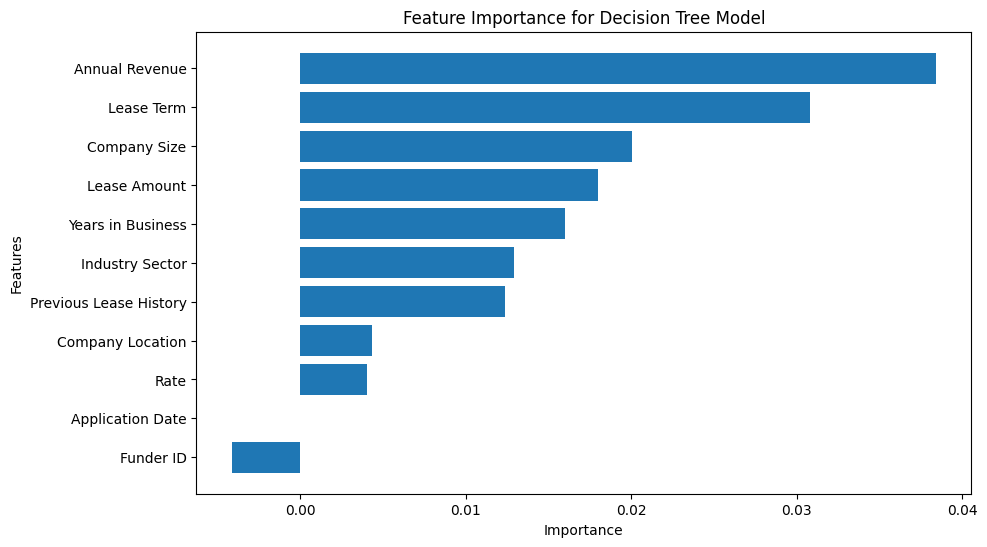

SVC
                   Feature  Importance
5               Lease Term    0.038001
6             Lease Amount    0.011471
9        Years in Business    0.009008
0                Funder ID    0.007530
4          Industry Sector    0.003941
3           Annual Revenue    0.001759
1         Company Location    0.001478
10                    Rate    0.000704
8         Application Date    0.000000
7   Previous Lease History   -0.002182
2             Company Size   -0.005771


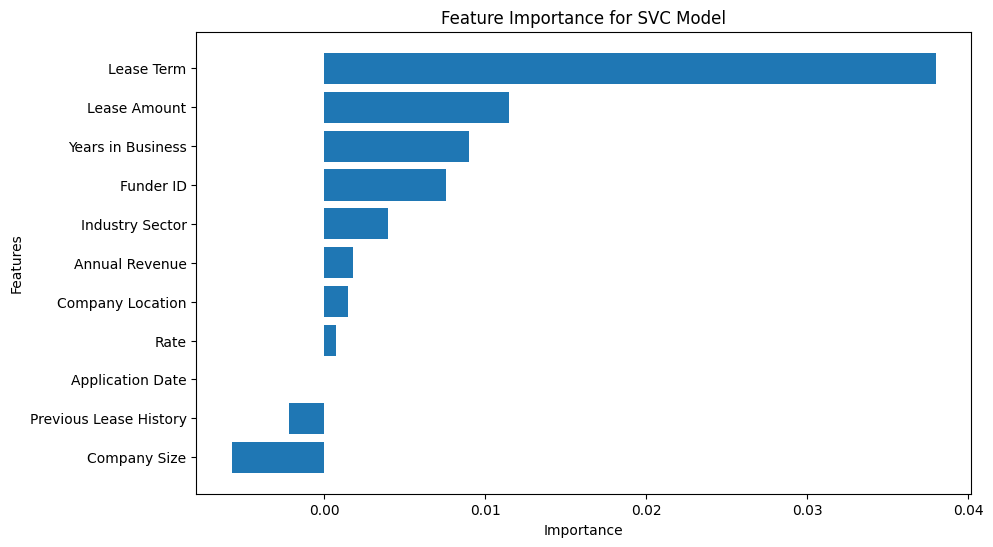

Logistic Regression
                   Feature  Importance
5               Lease Term    0.027868
6             Lease Amount    0.008234
9        Years in Business    0.004926
0                Funder ID    0.004574
10                    Rate    0.000704
4          Industry Sector    0.000493
8         Application Date    0.000000
3           Annual Revenue   -0.003308
1         Company Location   -0.004926
7   Previous Lease History   -0.005419
2             Company Size   -0.010486


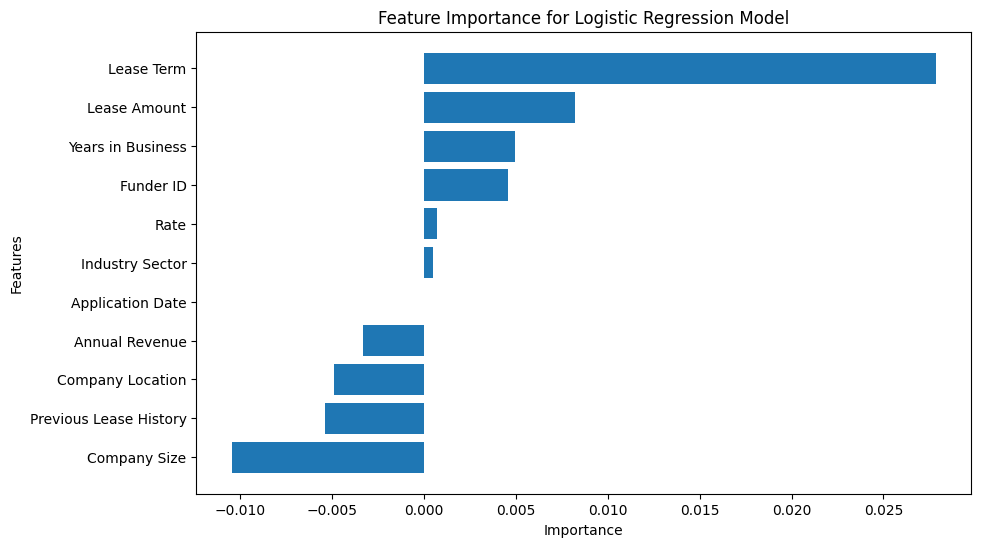

Random Forest
                   Feature  Importance
5               Lease Term    0.020619
0                Funder ID    0.008515
8         Application Date    0.000000
3           Annual Revenue   -0.001126
2             Company Size   -0.002604
6             Lease Amount   -0.003096
1         Company Location   -0.004011
10                    Rate   -0.004433
4          Industry Sector   -0.004856
7   Previous Lease History   -0.005278
9        Years in Business   -0.007319


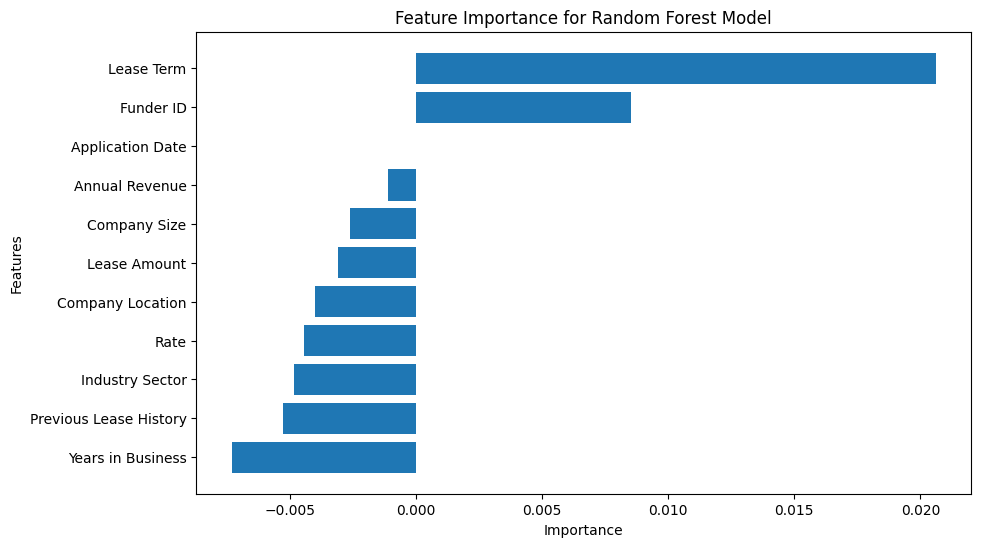

Bagging
                   Feature  Importance
5               Lease Term    0.037438
9        Years in Business    0.013089
0                Funder ID    0.010415
6             Lease Amount    0.009289
4          Industry Sector    0.003589
1         Company Location    0.000915
10                    Rate    0.000915
3           Annual Revenue    0.000352
8         Application Date    0.000000
7   Previous Lease History   -0.007248
2             Company Size   -0.009078


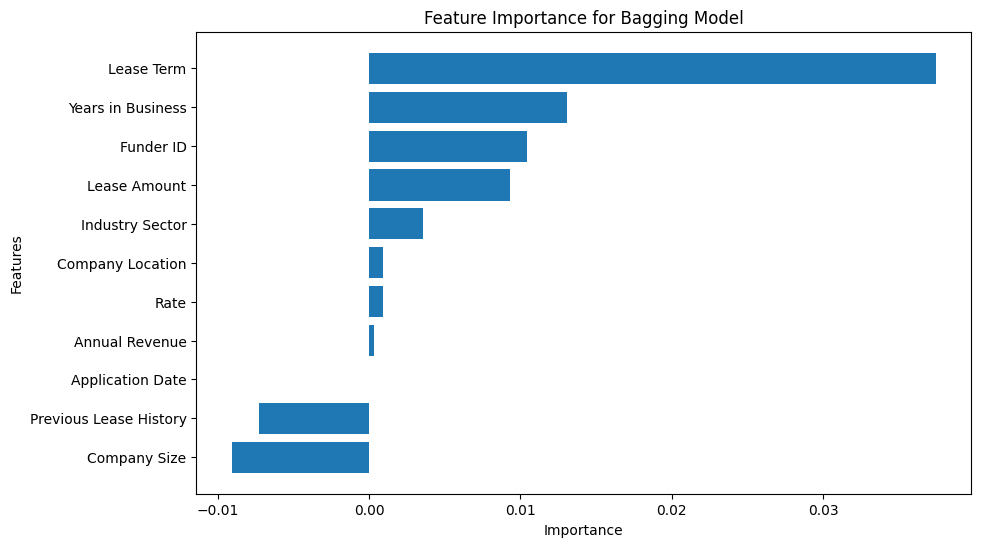

Baseline(classification)
                   Feature  Importance
0                Funder ID         0.0
1         Company Location         0.0
2             Company Size         0.0
3           Annual Revenue         0.0
4          Industry Sector         0.0
5               Lease Term         0.0
6             Lease Amount         0.0
7   Previous Lease History         0.0
8         Application Date         0.0
9        Years in Business         0.0
10                    Rate         0.0


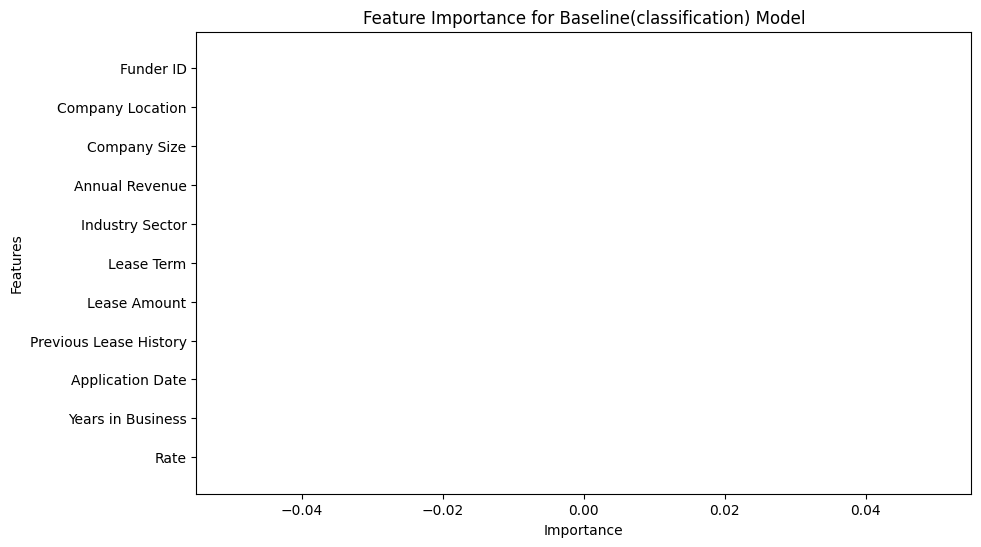

In [ ]:
from utils.data_modelling_helpers import plot_feature_importance


for model in best_models_and_bagging_and_baseline:
    print(model['Model Name'])
    plot_feature_importance(model, X_train, X_test, y_test, n_repeats=10, random_state=42)
